In [1]:
from fasp.loc import sbcgcDRSClient, DRSMetaResolver
from IPython.display import Image
import requests

drsClient = sbcgcDRSClient('/Users/forei/.keys/sevenbridges_keys.json', 's3')
tile_drs_id ='601fdb3c0a9d98531cd67f91'
print(drsClient.getObject(tile_drs_id))
tile_url = drsClient.getAccessURL(tile_drs_id)
Image(url=tile_url) 


{'id': '601fdb3c0a9d98531cd67f91', 'name': '5-13-11.jpg', 'size': 7452, 'checksums': [{'type': 'etag', 'checksum': '9a2afd36c2facc04a186676ea792043b-1'}], 'self_uri': 'drs://cgc-ga4gh-api.sbgenomics.com/601fdb3c0a9d98531cd67f91', 'created_time': '2021-02-07T12:21:16Z', 'updated_time': '2021-02-07T12:21:16Z', 'mime_type': 'application/json', 'access_methods': [{'type': 's3', 'region': 'us-east-1', 'access_id': 'aws-us-east-1'}]}


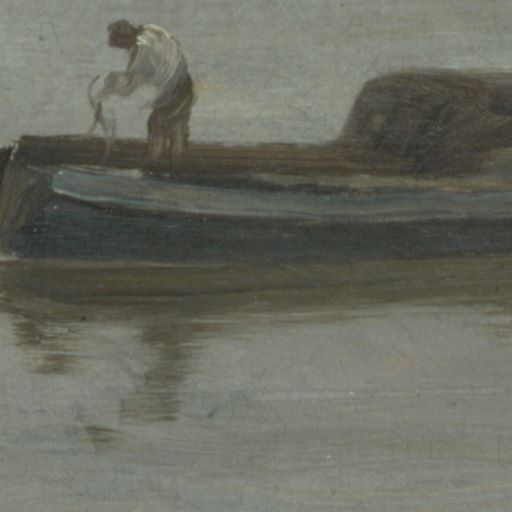

In [2]:
from PIL import Image as pim
tile_drs_ids = [['601fdb3c0a9d98531cd67f91','601fe543e036a06dd8522ecb'],
['601fe52be036a06dd8522ec4','601fe544e036a06dd8522ece']]

def assembleImage(idGrid):
    cols = len(idGrid[0])
    rows = len(idGrid)
    cw = 256
    ch = 256
    final_im = pim.new('RGB', (cw * cols, ch * rows))
    y_offset = 0
    for r in idGrid:
        x_offset = 0
        for c in r:
            im = pim.open(requests.get(drsClient.getAccessURL(c), stream=True).raw)
            final_im.paste(im, (x_offset,y_offset))
            x_offset += cw
        y_offset += ch
    return final_im

assembleImage(tile_drs_ids)

In [3]:
def assembleImage(idGrid, label=False):
    from PIL import ImageDraw
    mr = DRSMetaResolver(getReg=False)
    
    cols = len(idGrid[0])
    rows = len(idGrid)
    cw = 256
    ch = 256
    final_im = pim.new('RGB', (cw * cols, ch * rows))
    y_offset = 0
    for r in idGrid:
        x_offset = 0
        for c in r:
            im = pim.open(requests.get(mr.getAccessURL(c), stream=True).raw)
            if label:
                sourceLabel = 'data/{}.jpg'.format(c.split(':')[0])
                overlay = pim.open(sourceLabel)
                mask = pim.open(sourceLabel).convert('L')
                im = pim.composite(im, overlay, mask)
            final_im.paste(im, (x_offset,y_offset))
            x_offset += cw
        y_offset += ch
    return final_im

Invalid access token in /Users/forei/.keys/anvil_credentials.json


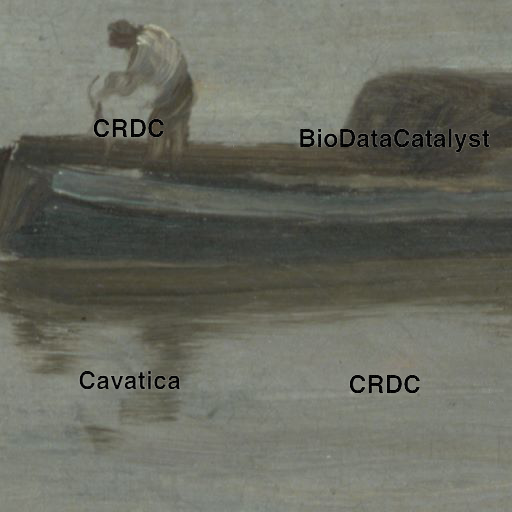

In [4]:
federated_tile_drs_ids = [['sbcgc:601fdb3c0a9d98531cd67f91','sbbdc:601ff5dbd86c36184354dec4'],
['sbcav:601ff3fe42e8973aba24f0fb','sbcgc:601fe544e036a06dd8522ece']]
assembleImage(federated_tile_drs_ids, True)

In [60]:
class PyramidViewer:
    
    def __init__(self, pyramidFile):
        self.cw = 256
        self.ch = 256

        import json
        with open(pyramidFile) as f:
            self.pyramid = json.load(f)
        
        self.levels = len(self.pyramid)
        self.cols = len(self.pyramid[str(self.levels-1)][0])
        self.rows = len(self.pyramid[str(self.levels-1)])
        self.final_im = pim.new('RGB', (self.cw * self.cols, self.ch * self.rows))
        self.grid = []
        for r in range(self.rows):
            self.grid.append([None] * self.cols)
        self.mr = DRSMetaResolver(getReg=False)



    def setPyramid(self, pyramid):
        self.pyramid=pyramid


    def getCurrentView(self, x, y, level):
        viewWidthTiles = 3
        viewHeightTiles = 2
        
        div = pow(2,5-level)
        lx = int(x/div)
        ly = int(y/div)

        view_im = pim.new('RGB', (self.cw * viewWidthTiles, self.ch * viewHeightTiles))
        y_offset = 0
        grid = self.pyramid[str(level)]
        for r in grid[ly:ly+viewHeightTiles]:
            x_offset = 0
            for c in r[lx:lx+viewWidthTiles]:
                if c != None:
                    im_url = self.mr.getAccessURL(c)
                    im = pim.open(requests.get(im_url, stream=True).raw)
                    view_im.paste(im, (x_offset,y_offset))
                x_offset += self.cw
            y_offset += self.ch
        zoom = pow(2, level)
        print("xTile:{} yTile:{} level:{} zoom:x{}".format(self.currentX, self.currentY, self.currentLevel,zoom))

        return view_im


        
    def startViewer(self, xTile, yTile, level):
        self.currentLevel = level
        self.currentX = xTile
        self.currentY = yTile
        return self.getCurrentView(xTile, yTile, level)


    def scroll(self, xIncrement, yIncrement):
        self.currentX += xIncrement
        self.currentY += yIncrement
        return self.getCurrentView(self.currentX, self.currentY, self.currentLevel)    
    
    def zoom(self, levelChange):
        self.currentLevel +=levelChange
        if levelChange > 0:
            self.currentX = int(self.currentX * 2 * levelChange)
            self.currentY = int(self.currentY * 2 * levelChange)

        if levelChange < 0:
            self.currentX = int(self.currentX / abs(2 * levelChange))
            self.currentY = int(self.currentY / abs(2 * levelChange))

        return self.getCurrentView(self.currentX, self.currentY, self.currentLevel)

Invalid access token in /Users/forei/.keys/anvil_credentials.json
xTile:13 yTile:11 level:5 zoom:x32


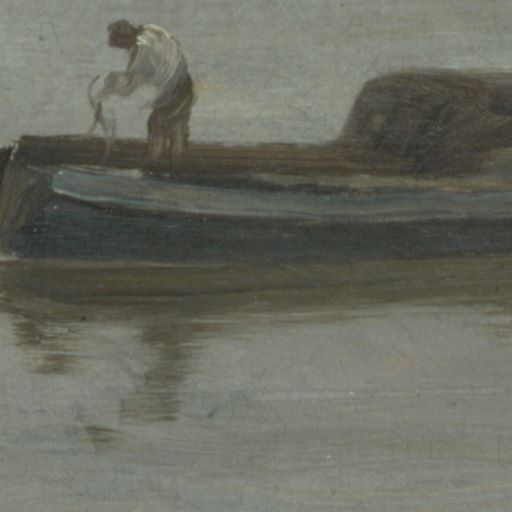

In [32]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
vwr = PyramidViewer(21,18, 'data/pyramid.json')
vwr.startViewer(13,11,5)

In [95]:
from IPython.display import Image, display
from io import BytesIO

vwr2 = PyramidViewer('data/pyramid.json')
features = {'Free scroll':None, 'Boatman':[13,11,5], 'Swan & Magpie':[15,5,5],
                'Boat':[15,8,3],'People on Bridge':[7,6,5]}
@interact
def show_viewer(xTile=widgets.IntSlider(min=0, max=vwr2.cols-1, step=1, value=15), 
                yTile=widgets.IntSlider(min=0, max=vwr2.rows-1, step=1, value=5), 
                level=widgets.IntSlider(min=0, max=vwr2.levels-1, step=1, value=5), 
                feature = features.keys()):
    
    if feature != 'Free scroll':
        f = features[feature]
        return vwr2.startViewer(f[0], f[1], f[2])                                          
    #return vwr2.startViewer(xTile, yTile, level)
    #display(vwr2.startViewer(xTile, yTile, level))
    im = vwr2.startViewer(xTile, yTile, level)
    b = BytesIO()
    im.save(b, format='jpeg')
    data = b.getvalue()
    display(Image(data=data,format='jpg', width=384, height=256, unconfined=True))


Invalid access token in /Users/forei/.keys/anvil_credentials.json


interactive(children=(IntSlider(value=15, description='xTile', max=20), IntSlider(value=5, description='yTile'…